In [1]:
import sys
sys.path.insert(1, '../src')

### A 1D Object under constant velocity

In [2]:
import filters.model

In [3]:
import numpy as np
import matplotlib.pyplot as plt

dt = 1
steps = 50

true_position = 0
true_velocity = 1

np.random.seed(1)

q = 1e-3 # Process noise
r = 1 # Measurement noise
c = 0.8 # Sensor measurement chance

true_states = []
measurements = []
kalman_estimates = []
kalman_covariances = []

# State transition matrix
F = np.array([
    [1, dt],
    [0, 1]
])

# Control input matrix
B = np.array([
    [0],
    [0]
])
# Observation matrix
H = np.array([
    [1, 0]
])

# Process noise covariance
Q = np.array([
    [0.25 * dt**4, 0.5 * dt**3],
    [0.5 * dt**3, dt**2]
]) * q

# Measurement noise covariance
R = np.array([
    [1]
]) * (r ** 2)

# Initial state estimate
x = np.array([
    [0],
    [0]
])

# Initial error covariance
P = np.array([
    [1, 0],
    [0, 1]
])

model = filters.model.KalmanFilter(2, F, Q)
accelerometer = filters.sensor.Sensor(H, R, lambda x : x)
model.logger.add_state_translation('position', 
                            np.array([[1, 0]]))
model.logger.add_state_translation('velocity', 
                            np.array([[0, 1]]))

In [4]:
for _ in range(steps):
    # Kalman Filter prediction step
    u = np.array([[0]])
    model.prediction_step(u)
    
    x = F @ x + B @ u
    P = F @ P @ F.T + Q

    # Calculate and log true position
    true_position += true_velocity * dt
    true_states.append([true_position, true_velocity])

    model.logger.log_value('position', 'reference', true_position)
    model.logger.log_value('velocity', 'reference', true_velocity)

    # Test if sensor was able to get measurement
    p = np.random.random()
    if p < c:
        # Simulate a noisy measurement
        z = np.array([[true_position + np.random.normal(0, np.sqrt(r))]])
        measurements.append(z[0, 0])
    
        # Kalman Filter correction step
        model.update_step(accelerometer, z)
        
        y = z - H @ x # Innovation
        S = H @ P @ H.T + R # Innovation covariance
        K = P @ H.T @ np.linalg.inv(S) # Kalman gain
        x = x + K @ y
        P = (np.eye(2) - K @ H) @ P
    else:
        measurements.append(None)

    model.log()

    kalman_estimates.append(x)
    kalman_covariances.append(P)

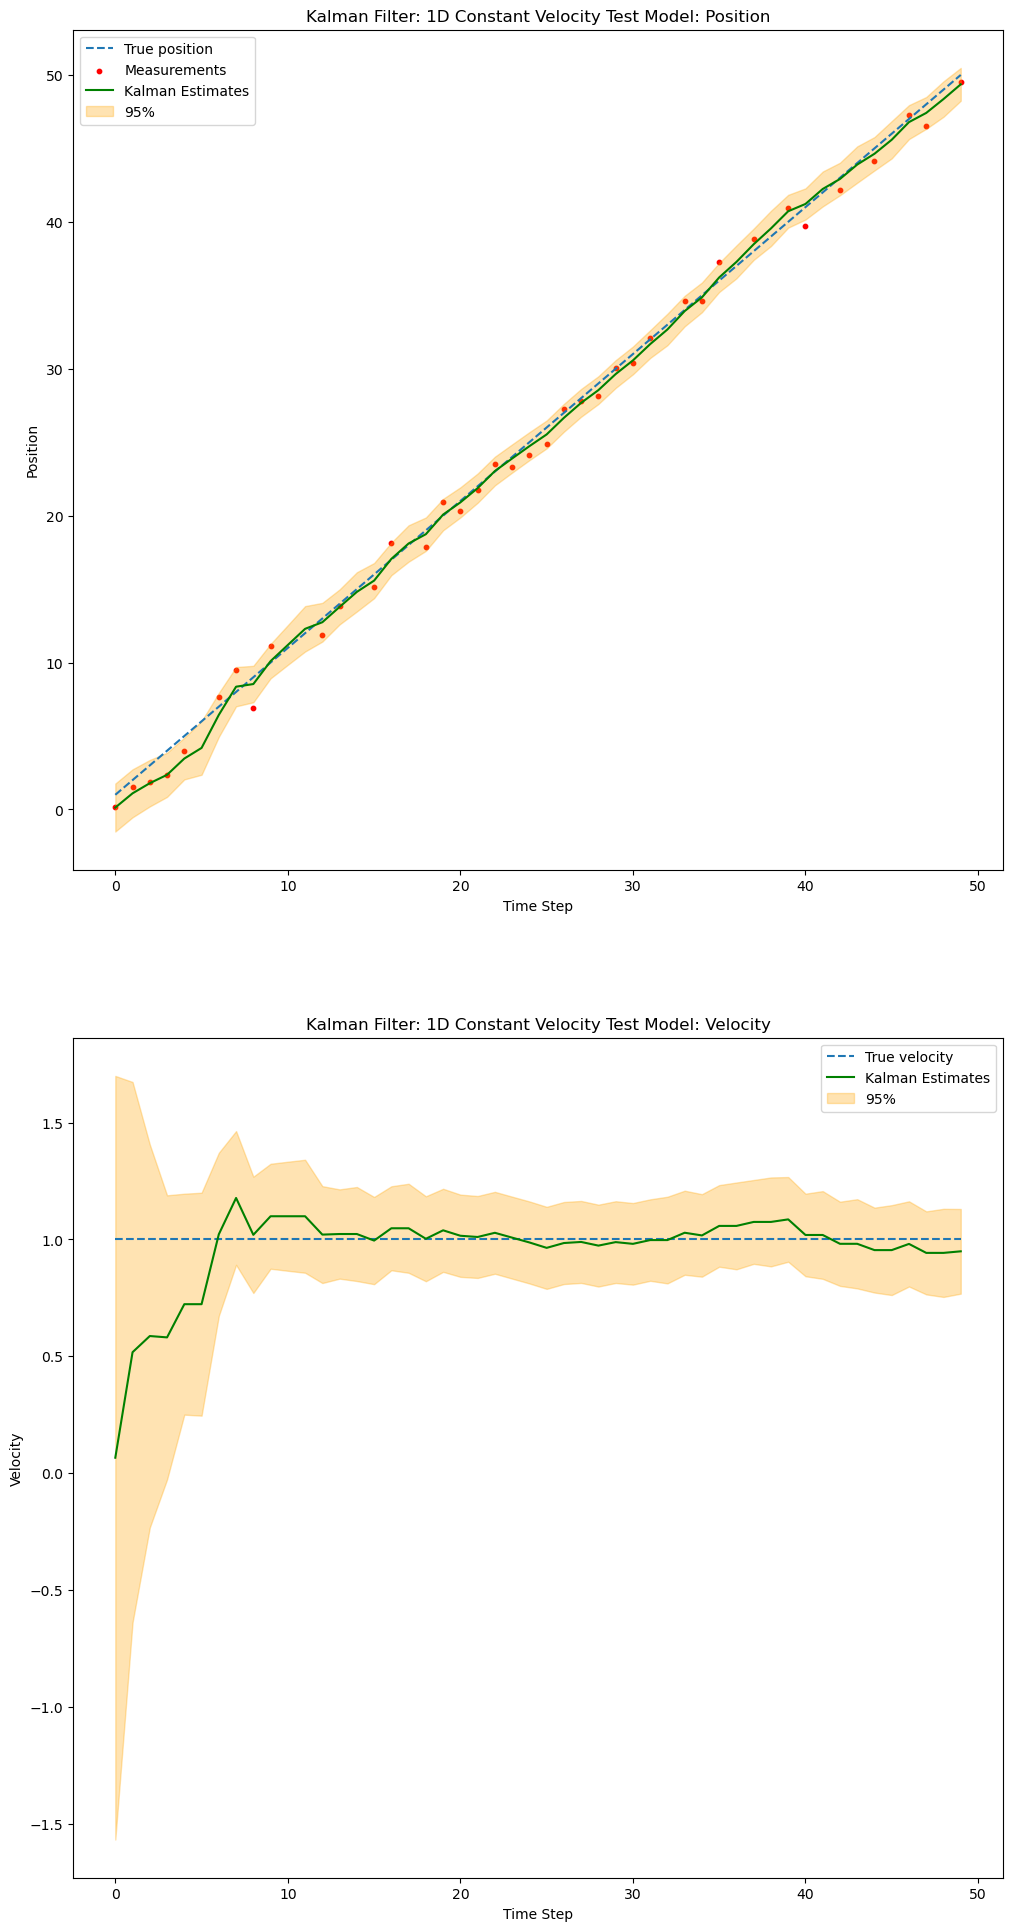

In [5]:
plt.figure(figsize=(12,24))

plt.subplot(2, 1, 1)
plt.plot([x[0] for x in true_states], label="True position", linestyle="--")
plt.scatter(range(steps), measurements, label="Measurements", color="red", s=10)
plt.plot([x[0, 0] for x in kalman_estimates], label="Kalman Estimates", color="green")
plt.fill_between(
    range(steps),
    [x[0,0] - 2 * np.sqrt(y[0, 0]) for x, y in zip(kalman_estimates, kalman_covariances)],
    [x[0,0] + 2 * np.sqrt(y[0, 0]) for x, y in zip(kalman_estimates, kalman_covariances)],
    color="orange",
    alpha=0.3,
    label="95%"
)
plt.title("Kalman Filter: 1D Constant Velocity Test Model: Position")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot([x[1] for x in true_states], label="True velocity", linestyle="--")
plt.plot([x[1, 0] for x in kalman_estimates], label="Kalman Estimates", color="green")
plt.fill_between(
    range(steps),
    [x[1,0] - 2 * np.sqrt(y[1, 1]) for x, y in zip(kalman_estimates, kalman_covariances)],
    [x[1,0] + 2 * np.sqrt(y[1, 1]) for x, y in zip(kalman_estimates, kalman_covariances)],
    color="orange",
    alpha=0.3,
    label="95%"
)
plt.title("Kalman Filter: 1D Constant Velocity Test Model: Velocity")
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.legend()

plt.show()

<Figure size 1200x2400 with 0 Axes>

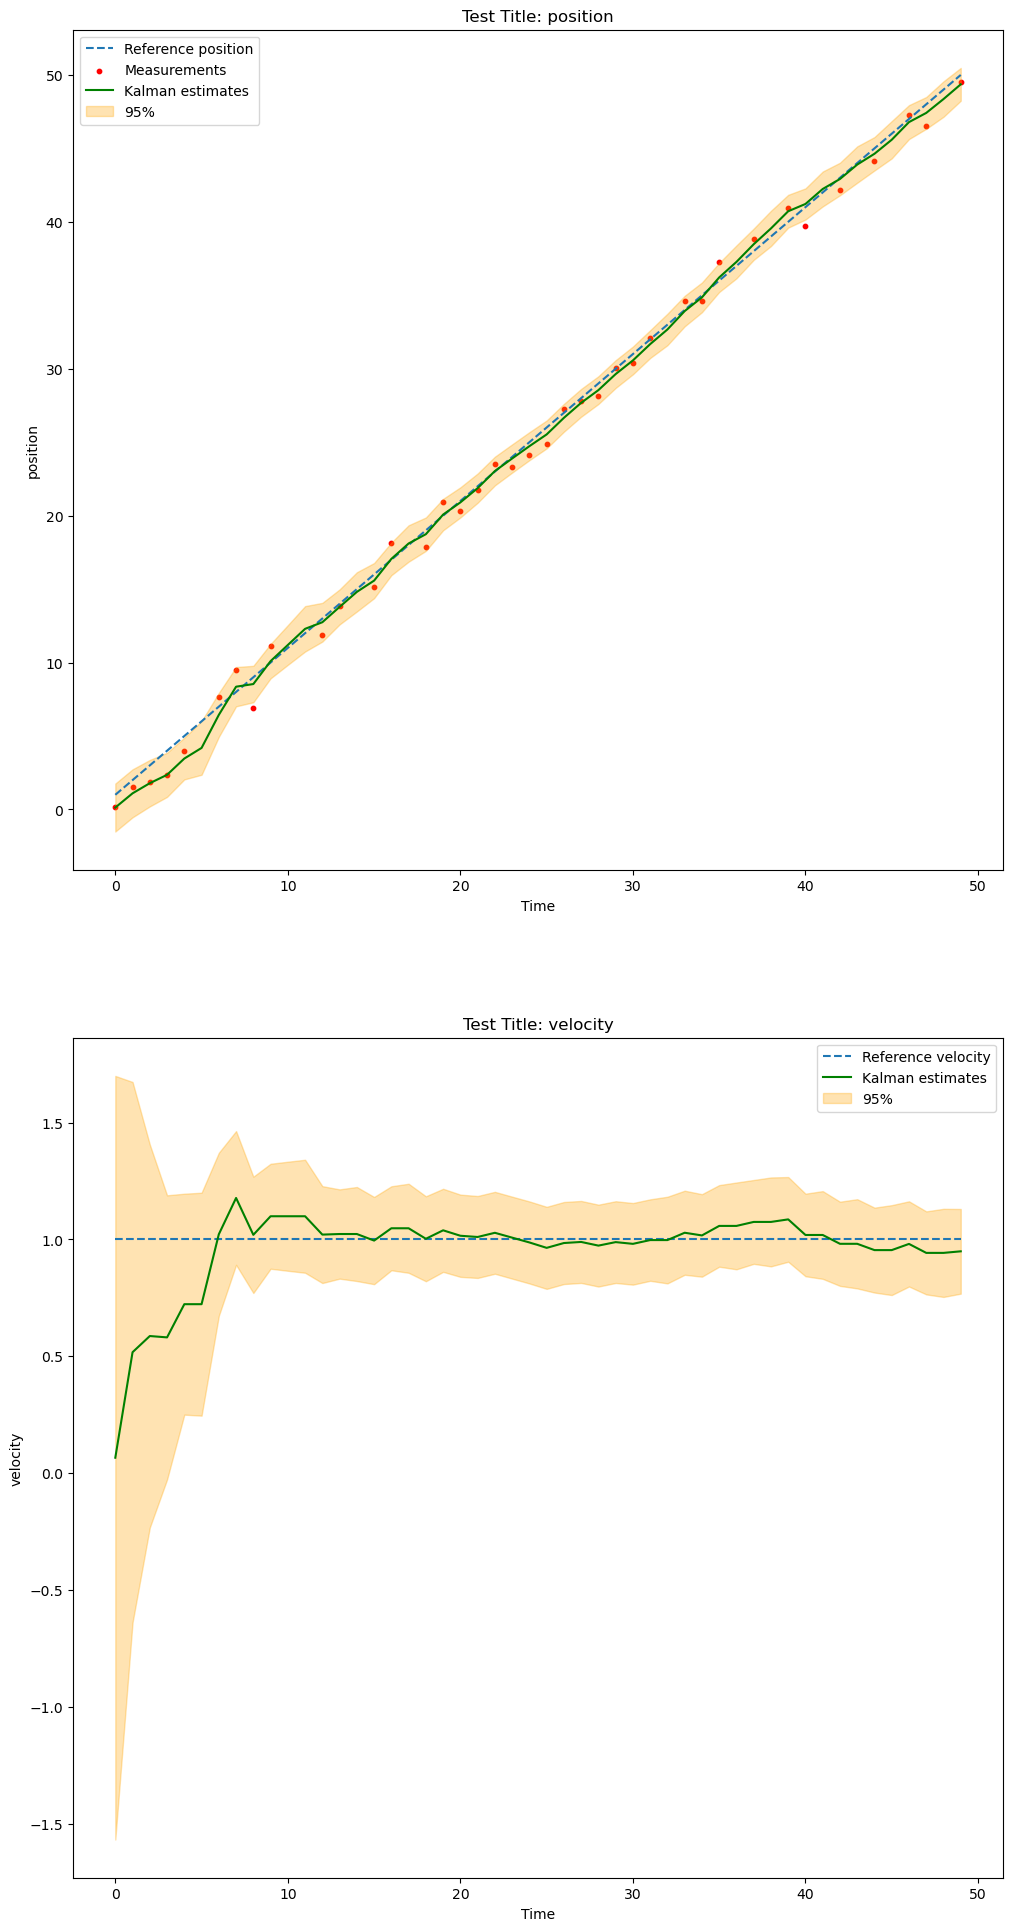

In [6]:
model.logger.plot()